In [1]:
!pip install transformers tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.2 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [4]:
import torch
print(torch.cuda.is_available())
# '''
#   CPU 환경일 경우: False
#   GPU 환경일 경우: True
# '''

True


# 데이터로드 및 전처리

In [5]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer
from torch.nn.utils.rnn import pad_sequence

# 데이터셋 로드
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/634_sample.csv')

# 데이터셋 분할 (학습 데이터와 검증 데이터로 나누기)
from sklearn.model_selection import train_test_split
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

# Tokenizer 불러오기
tokenizer = AutoTokenizer.from_pretrained("ainize/kobart-news")

# 데이터 전처리 함수 정의
def preprocess_data(data, max_input_length=512, max_target_length=150):
    input_texts = data['Text'].tolist()
    target_texts = data['Summary'].tolist()

    input_encodings = tokenizer(input_texts, truncation=True, padding='max_length', max_length=max_input_length, return_tensors='pt')
    target_encodings = tokenizer(target_texts, truncation=True, padding='max_length', max_length=max_target_length, return_tensors='pt')

    return input_encodings, target_encodings


# DataLoader 설정 및 모델 불러오기

In [6]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoModelForSeq2SeqLM, AdamW, get_scheduler

# 데이터 전처리
train_encodings, train_target_encodings = preprocess_data(train_data)
val_encodings, val_target_encodings = preprocess_data(val_data)

# DataLoader 설정
train_dataset = torch.utils.data.TensorDataset(
    train_encodings['input_ids'],
    train_encodings['attention_mask'],
    train_target_encodings['input_ids'],
    train_target_encodings['attention_mask']
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

val_dataset = TensorDataset(
    torch.tensor(val_encodings['input_ids']),
    torch.tensor(val_encodings['attention_mask']),
    torch.tensor(val_target_encodings['input_ids']),
)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True)

# 모델 불러오기
model = AutoModelForSeq2SeqLM.from_pretrained("ainize/kobart-news")

# GPU 사용 (선택적)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


<ipython-input-6-f5239fca2bb2>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(val_encodings['input_ids']),
<ipython-input-6-f5239fca2bb2>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(val_encodings['attention_mask']),
<ipython-input-6-f5239fca2bb2>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(val_target_encodings['input_ids']),


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(30000, 768, padding_idx=3)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(30000, 768, padding_idx=3)
      (embed_positions): BartLearnedPositionalEmbedding(1028, 768)
      (layers): ModuleList(
        (0-5): 6 x BartEncoderLayer(
          (self_attn): BartAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_layer_norm): LayerNorm((768,), eps=

# Optimizer 및 스케줄러 설정 및 학습 루프

In [7]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import AdamW, get_scheduler
import numpy as np
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

# Optimizer 및 스케줄러 설정
optimizer = AdamW(model.parameters(), lr=1e-5)
num_epochs = 20
scheduler = get_scheduler("linear", optimizer, num_warmup_steps=500, num_training_steps=len(train_loader) * num_epochs)
batch_size = 4

# Initialize early stopping variables
best_val_loss = float('inf')
patience = 3
current_patience = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for batch in train_loader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        target_ids = batch[2].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, decoder_input_ids=target_ids[:, :-1], labels=target_ids[:, 1:].contiguous())
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Average Loss: {average_loss:.4f}")

    # 검증 루프
    model.eval()
    val_losses = []

    for batch in val_loader:
        input_ids, attention_mask, target_ids = batch

        with torch.no_grad():
            outputs = model(input_ids=input_ids.to(device), attention_mask=attention_mask.to(device), decoder_input_ids=target_ids[:, :-1].to(device), labels=target_ids[:, 1:].contiguous().to(device))

        loss = outputs.loss
        val_losses.append(loss.item())

    avg_val_loss = np.mean(val_losses)
    print(f"Epoch [{epoch+1}/{num_epochs}] Validation Loss: {avg_val_loss:.4f}")

    # 얼리 스타핑 설정
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        current_patience = 0
        # 모델 저장
        model.save_pretrained("/content/drive/MyDrive/Colab Notebooks/oliveKobart12")
    else:
        current_patience += 1
        if current_patience >= patience:
            print("Early stopping")
            break

# 검증 데이터에 대한 성능 지표 계산
val_outputs = []

# 요약 원문, 요약문, 정답 데이터를 저장할 변수
sample_reference_text = ""
sample_candidate_text = ""
sample_gold_text = ""

for i in range(0, len(val_data), batch_size):
    input_batch = torch.tensor(val_encodings['input_ids'][i:i+batch_size]).to(device)
    attention_mask_batch = torch.tensor(val_encodings['attention_mask'][i:i+batch_size]).to(device)
    target_batch = torch.tensor(val_target_encodings['input_ids'][i:i+batch_size]).to(device)
    target_attention_mask_batch = torch.tensor(val_target_encodings['attention_mask'][i:i+batch_size]).to(device)

    with torch.no_grad():
        # 모델에 입력 전달하여 요약 생성
        outputs = model(input_ids=input_batch, attention_mask=attention_mask_batch, decoder_input_ids=target_batch[:, :-1], labels=target_batch[:, 1:].contiguous())

    loss = outputs.loss
    val_losses.append(loss.item())

    # 요약 생성
    generated_ids = model.generate(input_ids=input_batch, max_length=150, num_beams=4, length_penalty=2.0, early_stopping=True)
    val_outputs.extend(generated_ids.tolist())

    # 첫 번째 배치의 원문, 요약문, 정답 데이터 저장
    if i == 0:
        sample_reference_text = tokenizer.decode(target_batch[0], skip_special_tokens=True)
        sample_candidate_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
        sample_gold_text = tokenizer.decode(target_batch[0], skip_special_tokens=True)

# 검증 데이터에 대한 BLEU 점수 계산
reference_texts = [[tokenizer.decode(ids, skip_special_tokens=True) for ids in val_target_encodings['input_ids'][i]] for i in range(len(val_data))]
candidate_texts = [tokenizer.decode(ids, skip_special_tokens=True) for ids in val_outputs]

# 가장 짧은 길이의 텍스트 리스트 길이 계산
min_length = min(len(reference_texts), len(candidate_texts))

# 리스트 개수를 가장 짧은 길이에 맞춤
reference_texts = reference_texts[:min_length]
candidate_texts = candidate_texts[:min_length]

# BLEU 점수 계산
bleu_score = corpus_bleu([reference_texts], [candidate_texts], smoothing_function=SmoothingFunction().method1)

avg_val_loss = np.mean(val_losses)

print(f"Epoch [{epoch+1}/{num_epochs}] Validation Loss: {avg_val_loss:.4f} BLEU Score: {bleu_score:.4f}")

# 원문, 요약문, 정답 데이터 출력
print("\n원문:")
print(sample_reference_text)
print("\n요약문:")
print(sample_candidate_text)
print("\n정답데이터:")
print(sample_gold_text)

# 학습된 모델 저장 (원하는 경로에 저장)
model.save_pretrained("/content/drive/MyDrive/Colab Notebooks/oliveKobart12")


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch [1/20] Average Loss: 1.1363
Epoch [1/20] Validation Loss: 0.8789
Epoch [2/20] Average Loss: 0.8100
Epoch [2/20] Validation Loss: 0.6436
Epoch [3/20] Average Loss: 0.6042
Epoch [3/20] Validation Loss: 0.5226
Epoch [4/20] Average Loss: 0.4874
Epoch [4/20] Validation Loss: 0.4592
Epoch [5/20] Average Loss: 0.3925
Epoch [5/20] Validation Loss: 0.4116
Epoch [6/20] Average Loss: 0.3297
Epoch [6/20] Validation Loss: 0.3838
Epoch [7/20] Average Loss: 0.2853
Epoch [7/20] Validation Loss: 0.3714
Epoch [8/20] Average Loss: 0.2536
Epoch [8/20] Validation Loss: 0.3644
Epoch [9/20] Average Loss: 0.2254
Epoch [9/20] Validation Loss: 0.3598
Epoch [10/20] Average Loss: 0.2033
Epoch [10/20] Validation Loss: 0.3546
Epoch [11/20] Average Loss: 0.1861
Epoch [11/20] Validation Loss: 0.3511
Epoch [12/20] Average Loss: 0.1695
Epoch [12/20] Validation Loss: 0.3519
Epoch [13/20] Average Loss: 0.1555
Epoch [13/20] Validation Loss: 0.3637
Epoch [14/20] Average Loss: 0.1440
Epoch [14/20] Validation Loss: 0.3

<ipython-input-7-40953a97f02a>:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_batch = torch.tensor(val_encodings['input_ids'][i:i+batch_size]).to(device)
<ipython-input-7-40953a97f02a>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask_batch = torch.tensor(val_encodings['attention_mask'][i:i+batch_size]).to(device)
<ipython-input-7-40953a97f02a>:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_batch = torch.tensor(val_target_encodings['input_ids'][i:i+batch_size]).to(device)
<ipython-input-7-40953a97f02a>:81

Epoch [14/20] Validation Loss: 0.3533 BLEU Score: 0.0000

원문:
피고인이 사건 범행을 인정하면서 반성하고 있는 피해자와 원만히 합의한 동종 범죄로 처벌 받은 전력이 없는 점과 밖에 피고인의 연령 환경 범행의 동기와 경위 범행 정황 형법 51조가 정한 여러 양형 조건을 종합적으로 하여 주문과 같이 형을 정한다.

요약문:
피고인이 사건 범행을 인정하면서 반성하고 있는 피해자와 원만히 합의한 동종 범죄로 처벌 받은 전력이 없는 점과 밖에 피고인의 연령 환경 범행의 동기와 경위 범행 정황 형법 51조가 정한 여러 양형 조건을 종합적으로 고려 하여 주문과 같이 형을 정한다.

정답데이터:
피고인이 사건 범행을 인정하면서 반성하고 있는 피해자와 원만히 합의한 동종 범죄로 처벌 받은 전력이 없는 점과 밖에 피고인의 연령 환경 범행의 동기와 경위 범행 정황 형법 51조가 정한 여러 양형 조건을 종합적으로 하여 주문과 같이 형을 정한다.


# 검증 루프 및 모델 저장

In [8]:
from transformers import BartForConditionalGeneration

# 저장된 모델 불러오기
model_path = "/content/drive/MyDrive/Colab Notebooks/oliveKobart12"
model = BartForConditionalGeneration.from_pretrained(model_path)

# 모델을 GPU로 옮기기
model.to(device)

# 텍스트 요약 테스트
input_text = "피고인은 원심에서도 이 부분 항소이유와 동일한 취지의 주장을 하였고, 원심은 피고인과 변호인의 주장에 대한 판단이라는 제목 아래 이에 관한 판단을 자세하게 설시하여 위 주장을 배척하였다.원심의 판단을 기록과 면밀히 대조하여 살펴보면 충분히 정당하다고 수긍할 수 있고, 원심판결에 피고인의 주장과 같은 사실오인의 위법이 있다고 판단되지 않는다. 따라서 피고인의 이 부분 주장은 이유 없다. 이 사건 범행은 피고인이 여러 명이 같이 자고 있는 방에서 술에 만취하여 잠이 든 19세의 피해자를 간음한 사안으로 그 죄질이 좋지 않다. 피해자가 이 사건 범행으로 인하여 상당한 성적 수치심과 정신적 고통을 겪고 있을 것임에도, 피고인은 피해자와 합의 하에 성관계를 가졌다고 주장하는 등 납득할 수 없는 변명으로 일관하고 있는 점, 피고인은 특수강간 등의 범죄사실로 소년보호처분을 받은 전력이 있는 점 등은 피고인에게 불리한 사정이다. 반면, 피고인이 당심에 이르러 피해자와 합의한 점 등은 피고인에게 유리한 사정이다. 그밖에 피고인의 나이, 성행, 환경, 가족관계, 범행의 동기와 경위, 범행의 방법과 결과, 범행 전후의 정황 등 여러 가지 양형의 조건들 및 양형기준의 권고형량범위를 종합하여 보면, 원심이 피고인에 대하여 선고한 형이 너무 무거워서 부당하다고 판단된다. 따라서 피고인의 이 부분 주장은 이유 있다."
input_ids = tokenizer.encode(input_text, return_tensors="pt", max_length=1024, truncation=True).to(device)

# 모델에 입력 전달하여 요약 생성
generated_ids = model.generate(input_ids.to(device), max_length=150, num_beams=4, length_penalty=2.0, early_stopping=True)

# 요약문 출력
generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
print("요약문:", generated_text)



You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


요약문: 밖에 피고인의 나이, 환경, 가족관계, 범행의 동기와 경위, 범행의 방법과 결과, 범행 전후의 정황 등을 종합하여 보면, 원심이 피고인에 대하여 선고한 형이 너무 무거워서 부당 하다고 판단된다. 원심의 판단을 기록과 면밀히 대조하여 살펴보면 충분히 정당하다고 수긍할 수 있고, 원심판결에 피고인의 주장과 같은 사실 오인의 위법이 있다고 피고인은 원심에서도 이 부분 항소 이유와 동일한 취지의 주장을 하였고, 원심은 피고인과 변호인의 주장에 대한 판단이라는 제목 아래 이에 관한 판단을 자세하게 설시하여 위 주장을 배척하였다. 따라서 피고인의 이 부분 주장은 이유 없다.


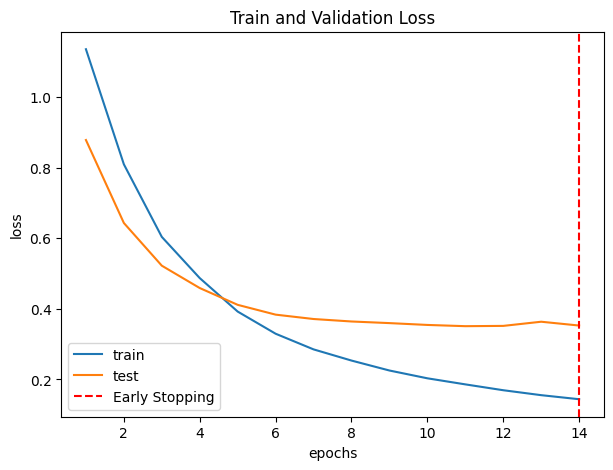

In [10]:
import matplotlib.pyplot as plt


epochs = range(1, 15)  # 에포크 수에 따라 범위를 조절하세요
train_loss = [1.1363, 0.8100, 0.6042, 0.4874, 0.3925, 0.3297, 0.2853, 0.2536, 0.2254, 0.2033, 0.1861, 0.1695, 0.1555, 0.1440]
val_loss = [0.8789, 0.6436, 0.5226, 0.4592, 0.4116, 0.3838, 0.3714, 0.3644, 0.3598, 0.3546, 0.3511, 0.3519, 0.3637, 0.3529]

plt.figure(figsize=(7, 5))
plt.plot(epochs, train_loss, label='train', linestyle='-')
plt.plot(epochs, val_loss, label='test', linestyle='-')

# Early stopping 표시
plt.axvline(x=14, color='r', linestyle='--', label='Early Stopping')

plt.title('Train and Validation Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()
